In [1]:
import joblib
from pathlib import Path
import os
import mne
import numpy as np
TARGET_SAMPLING_RATE=250
window_size=2500
overlap=0.5 #How much overlap is desired between consecutive windows- 50% overlap between windows 

In [2]:
os.environ['MNE_USE_CUDA'] = 'true' 
mne.utils.set_config('MNE_USE_CUDA', 'true') 
mne.cuda.init_cuda(ignore_config=True)  

Now using CUDA device 0
Enabling CUDA with 10.83 GB available memory


In [3]:
'''
Same as the logic inside the for-loop used for creating the dataset from all the .set files
Cut down to work with a single file and not worry about the file name (PREP)
'''
def process_single_file(file_path, window_size=2500):

    #Preprocessing steps
    raw = mne.io.read_raw_eeglab(file_path, preload=True,verbose=False)
    raw.set_eeg_reference('average', projection=True,verbose=False)
    raw.resample(TARGET_SAMPLING_RATE, npad="auto",verbose=False)
    raw.filter(1., 30., fir_design='firwin', n_jobs='cuda',verbose=False)
    
    ica = mne.preprocessing.ICA(n_components=15, random_state=22, max_iter=1000, method='picard',verbose=False)
    ica.fit(raw,verbose=False)
    raw = ica.apply(raw,verbose=False)
    
    data = raw.get_data().T
    
    #Make multiple windows
    windows = []
    if data.shape[0] >= window_size:
        stride= int(window_size*(1-overlap))
        for start in range(0, data.shape[0] - window_size + 1, stride):
            window = data[start:start + window_size, :]
            windows.append(window)
        
    return np.stack(windows)

#Predict a result for the input file
def predict_file(file_path, model, scaler, window_size=2500):
    windows = process_single_file(file_path, window_size)
    X = windows.reshape(windows.shape[0], -1)
    X_scaled = scaler.transform(X)
    
    #Predictions for all windows
    predictions = model.predict(X_scaled)
    probabilities = model.predict_proba(X_scaled)
    
    #Majority voting
    final_prediction = np.bincount(predictions).argmax()
    final_probability = np.mean(probabilities, axis=0)
    #file_prediction_prob_avg = np.argmax(final_probability)
    return final_prediction, final_probability

In [4]:
scaler=joblib.load('scaler.gz')
lr=joblib.load("lr.joblib")
lr_cv=joblib.load("lr_cv.joblib")
rfc=joblib.load("rfc.joblib")
svm=joblib.load("svm.joblib")
models=[lr,lr_cv,rfc,svm]
#Load all the the trained models and store them in a list

model_names=["Logistic Regression","Logistic Regression with CV","Random Forest Classifier","SVM"] #Model names

In [5]:
results=[[],[],[],[]] 
#List at index 0 stores results of basic logistic regression
#List at index 1 stores results of logistic regression with cross validation
#List at index 2 stores results of random forest classifier
#List at index 3 stores results of SVM

In [6]:
#The models will be tested on all unseen data (data stored in fresh data folder)
data_dir = Path("fresh data")
for file_path in data_dir.glob("*.set"):
    file_name = file_path.stem
    if "PREP" not in file_name:
        for i,model in enumerate(models): #Traverse through the models list because we want to test all models
            #The code below is the same as predicting results for a single file with a model
            prediction, probability = predict_file(file_path, model, scaler, window_size=window_size)
            prediction_label="Parkinson's" if prediction == 1 else "Non-Parkinson's"
            number=int(file_name.split('_')[0])
            label = "Parkinson's" if number % 2 == 1 else "Non-Parkinson's"
            result=[file_name,prediction_label,max(probability)*100,label]
            results[i].append(result)

In [7]:
#Print the results for simple LR for understanding purposes
for result in results[0]:
    print(result)

['05_eyesClosed', "Non-Parkinson's", np.float64(58.00931659385044), "Parkinson's"]
['05_eyesOpen', "Non-Parkinson's", np.float64(63.62026426111844), "Parkinson's"]
['16_eyesClosed', "Non-Parkinson's", np.float64(64.85422661237165), "Non-Parkinson's"]
['16_eyesOpen', "Non-Parkinson's", np.float64(53.755706080040724), "Non-Parkinson's"]
['18_eyesClosed', "Non-Parkinson's", np.float64(51.615705675411505), "Non-Parkinson's"]
['18_eyesOpen', "Non-Parkinson's", np.float64(81.39245538390651), "Non-Parkinson's"]
['19_eyesClosed', "Non-Parkinson's", np.float64(62.93062497582087), "Parkinson's"]
['19_eyesOpen', "Non-Parkinson's", np.float64(55.69197657083976), "Parkinson's"]
['31_eyesClosed', "Non-Parkinson's", np.float64(71.91456712595868), "Parkinson's"]
['31_eyesOpen', "Non-Parkinson's", np.float64(65.62412694050094), "Parkinson's"]
['32_eyesClosed', "Non-Parkinson's", np.float64(69.67442864246081), "Non-Parkinson's"]
['32_eyesOpen', "Parkinson's", np.float64(55.69129059643394), "Non-Parkinso

In [8]:
#Store the results 2D-list as a CSV file
import csv
file_path = "results.csv"
with open(file_path, 'w', newline='') as csvfile:

    writer = csv.writer(csvfile)
    writer.writerows(results) 

In [9]:
#Store the results 2D-list as a pickle file. This maintained data-integrity (as the data is of mixed types)
import pickle
with open("results.pkl", mode='wb') as file:
    pickle.dump(results, file)

In [10]:
#Code to load the results pickle file
#Done to ensure the save logic actually works
import pickle
with open("results.pkl", mode='rb') as file:
    results_copy = pickle.load(file)

#Print file names
print(results_copy)
for content in results_copy[0]:
    print(content[0])

[[['05_eyesClosed', "Non-Parkinson's", np.float64(58.00931659385044), "Parkinson's"], ['05_eyesOpen', "Non-Parkinson's", np.float64(63.62026426111844), "Parkinson's"], ['16_eyesClosed', "Non-Parkinson's", np.float64(64.85422661237165), "Non-Parkinson's"], ['16_eyesOpen', "Non-Parkinson's", np.float64(53.755706080040724), "Non-Parkinson's"], ['18_eyesClosed', "Non-Parkinson's", np.float64(51.615705675411505), "Non-Parkinson's"], ['18_eyesOpen', "Non-Parkinson's", np.float64(81.39245538390651), "Non-Parkinson's"], ['19_eyesClosed', "Non-Parkinson's", np.float64(62.93062497582087), "Parkinson's"], ['19_eyesOpen', "Non-Parkinson's", np.float64(55.69197657083976), "Parkinson's"], ['31_eyesClosed', "Non-Parkinson's", np.float64(71.91456712595868), "Parkinson's"], ['31_eyesOpen', "Non-Parkinson's", np.float64(65.62412694050094), "Parkinson's"], ['32_eyesClosed', "Non-Parkinson's", np.float64(69.67442864246081), "Non-Parkinson's"], ['32_eyesOpen', "Parkinson's", np.float64(55.69129059643394), 

In [11]:
import pandas as pd
#Create a dataframe for each results list in the results 2D matrix
dataframes=[]#Lsit to store the dataframes for each model

columns=["File","Prediction","Probability","Actual"] #Columns for the dataframe

#All file names in the unseen data folder - Serves no purpose
file_names=[]
for content in results[0]:
    file_names.append(content[0])


for result in results:#Traverse the results 2D matrix
    df=pd.DataFrame(result,columns=columns)#Create a dataframe from each result list
    df["Correct"] = (df['Prediction'] == df['Actual']).astype(int)#Create a new column for each df
                                                                  #the new correct column tracks whether a correct prediction prediction was made by comparing the values of the Prediction and Actaul columns 
    dataframes.append(df)#Add the dataframe to the dataframes list

#Print all dataframes
for df in dataframes:
    print(df)
    print("------------------")

             File       Prediction  Probability           Actual  Correct
0   05_eyesClosed  Non-Parkinson's    58.009317      Parkinson's        0
1     05_eyesOpen  Non-Parkinson's    63.620264      Parkinson's        0
2   16_eyesClosed  Non-Parkinson's    64.854227  Non-Parkinson's        1
3     16_eyesOpen  Non-Parkinson's    53.755706  Non-Parkinson's        1
4   18_eyesClosed  Non-Parkinson's    51.615706  Non-Parkinson's        1
5     18_eyesOpen  Non-Parkinson's    81.392455  Non-Parkinson's        1
6   19_eyesClosed  Non-Parkinson's    62.930625      Parkinson's        0
7     19_eyesOpen  Non-Parkinson's    55.691977      Parkinson's        0
8   31_eyesClosed  Non-Parkinson's    71.914567      Parkinson's        0
9     31_eyesOpen  Non-Parkinson's    65.624127      Parkinson's        0
10  32_eyesClosed  Non-Parkinson's    69.674429  Non-Parkinson's        1
11    32_eyesOpen      Parkinson's    55.691291  Non-Parkinson's        0
------------------
             File  

In [12]:
accuracies = [df['Correct'].mean()*100 for df in dataframes] #Accuracies of prediction of each model on unseen data (data not involved in training)

for i,acc in enumerate(accuracies):
    print("Accuracy for Dataset ",i,":",acc,"%") #Print the accuracies

Accuracy for Dataset  0 : 41.66666666666667 %
Accuracy for Dataset  1 : 41.66666666666667 %
Accuracy for Dataset  2 : 58.333333333333336 %
Accuracy for Dataset  3 : 50.0 %


In [13]:
combined_df = pd.concat(dataframes, ignore_index=True) #Combine all the model dataframes
combined_df

,File,Prediction,Probability,Actual,Correct
0,05_eyesClosed,Non-Parkinson's,58.009317,Parkinson's,0
1,05_eyesOpen,Non-Parkinson's,63.620264,Parkinson's,0
2,16_eyesClosed,Non-Parkinson's,64.854227,Non-Parkinson's,1
3,16_eyesOpen,Non-Parkinson's,53.755706,Non-Parkinson's,1
4,18_eyesClosed,Non-Parkinson's,51.615706,Non-Parkinson's,1
5,18_eyesOpen,Non-Parkinson's,81.392455,Non-Parkinson's,1
6,19_eyesClosed,Non-Parkinson's,62.930625,Parkinson's,0
7,19_eyesOpen,Non-Parkinson's,55.691977,Parkinson's,0
8,31_eyesClosed,Non-Parkinson's,71.914567,Parkinson's,0
9,31_eyesOpen,Non-Parkinson's,65.624127,Parkinson's,0


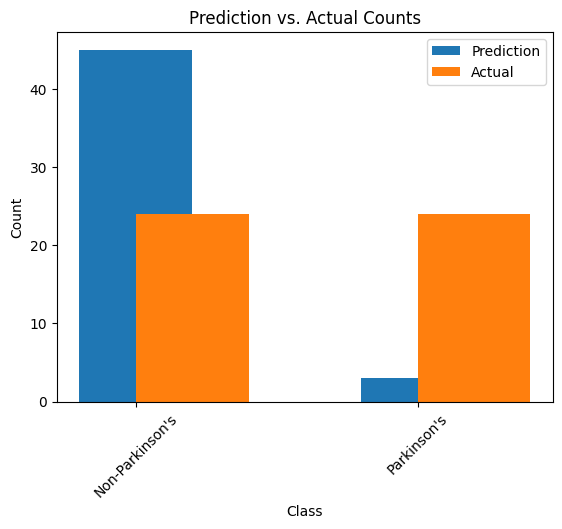

In [14]:
import matplotlib.pyplot as plt

#Count predictions and actual
prediction_counts=combined_df['Prediction'].value_counts()
actual_counts=combined_df['Actual'].value_counts()

labels=prediction_counts.index
x=range(len(labels))
#Plot the actual count of a label vs how many were predicted for tha label (accross all models)
plt.bar(x,prediction_counts.values,width=0.4,label='Prediction',align='center')
plt.bar(x,actual_counts.values,width=0.4,label='Actual',align='edge')

plt.xticks(x,labels,rotation=45)
plt.xlabel("Class")
plt.ylabel("Count")
plt.title("Prediction vs. Actual Counts")
plt.legend()
plt.show()


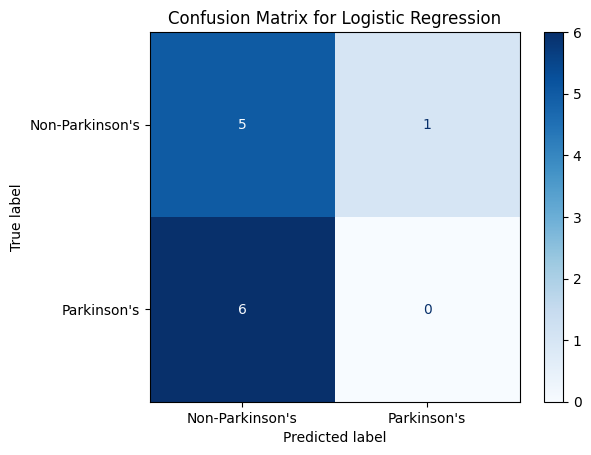

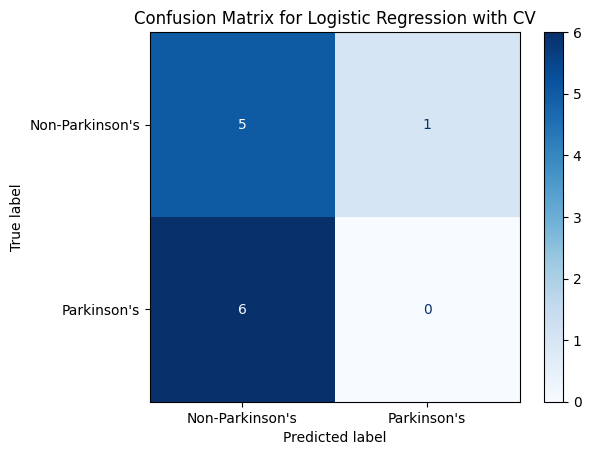

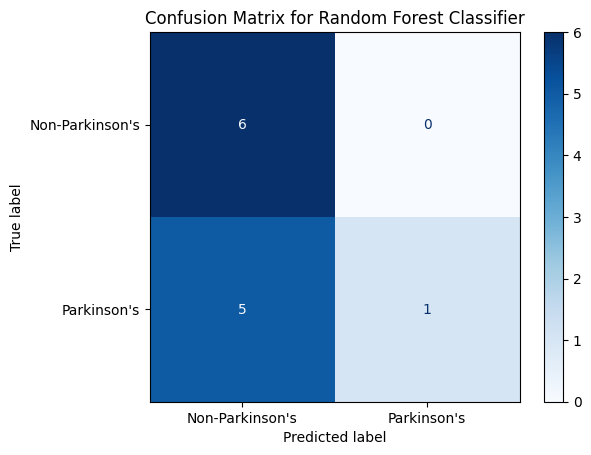

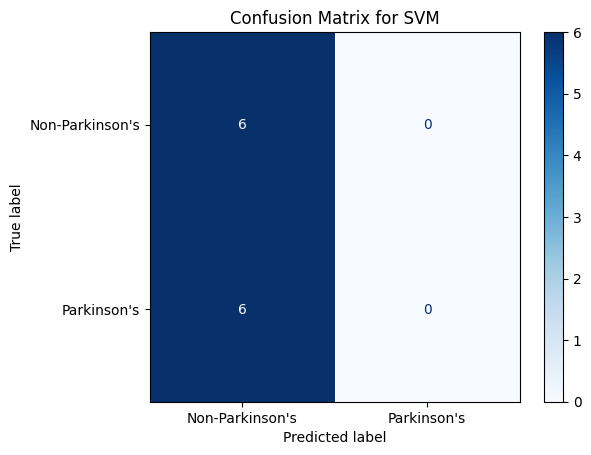

In [16]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Generate a confusion matrix for the data frame passed
#The index is used to get the name of the model to wghich the dataframe belongs
def generate_confusion_matrix(df, index):
    actual=df['Actual']
    predicted=df['Prediction']
    cm=confusion_matrix(actual,predicted,labels=labels)
    disp=ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=labels)
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix for {model_names[index]}")
    plt.show()

#Traverse the dataframes list and create a dataframe for each model 
for i, df in enumerate(dataframes):
    generate_confusion_matrix(df, i)
